In [196]:
import numpy as np
import pandas as pd
import copy
import scipy.linalg
from datetime import datetime

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
print(torch.cuda.is_available())

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline 

from tqdm.notebook import tqdm


True


# Control model using reinforcement learning.

This project is the Monte-Carlo challenge 2 of course MAP556. 
The detailed description is given in [MCC2_notes](./MCC2_notes.pdf).

## Define the control model

In [179]:
# define the model
class Control(nn.Module):
    
    def __init__(self, dim=2, dim_hid=[12], CUDA=False):
        super(Control, self).__init__()
        if CUDA and torch.cuda.is_available():
            self.device = torch.device('cuda:0')
        else:
            self.device = torch.device('cpu')
            
        # Define layers. 
        self.hidden = nn.ModuleList()
        # The first layer.
        self.hidden.append(nn.Linear(dim+1, dim_hid[0]))
        for i in range(1, len(dim_hid)):
            self.hidden.append(nn.Linear(dim_hid[i-1], dim_hid[i]))
        
        # The output layer.
        self.out = nn.Linear(dim_hid[-1], dim)
        
    def forward(self, t, X):
        '''
        Params:
        --------
        X: arr, of shape (num, dim).
        '''
        num = len(X)
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X)
        X = X.to(self.device).float()
        t = torch.ones(num, 1).to(self.device).float()*t
        X = torch.cat([t, X], axis=1)
        
        for i, layer in enumerate(self.hidden):
#             X = F.relu(layer(X))
            X = F.leaky_relu(layer(X))
#             if i%2 == 0:
#                 X = F.relu(layer(X))
#             else:
#                 X = 
        
        
        X = self.out(X)
        return X
    
    def predict(self, t, X):
        with torch.no_grad():
            u = self(t, X)
        return u.cpu().numpy()
        
        

## Define the wind generator.
The wind is a random process follows the following stochastique equation,
$$dV_t = -A V_t + \sigma dW_t.$$

In [36]:
class Vent:
    def __init__(self, A, sigma, V0):
        '''
        * Params:
        ----------
        A, sigma : dVt = -AVtdt + sigmadWt.
        V0, of shape (2, )
        '''
        assert A.shape[0] == A.shape[1] and A.shape[0] == V0.shape[0]
        self.dim = V0.shape[0]
        self. A = A
        self.sigma = sigma
        self.V0 = V0
    
    def __call__(self, num, n, T=10., V0=None, method='exact'):
        '''
        * Return:
        ---------
        Vt, of shape (num, n+1, dim).
        '''
        if V0 is None:
            V0 = self.V0
        
        if method == 'exact':
            return self.gen(num, n, T, V0=V0)
        elif method == 'euler':
            return self.euler(num, n, T=T, V0=V0)
        else:
            raise(f'Unkown method {method}.')
            

    def gen(self, num, n, T, V0=None):
        if V0 is None:
            V0 = self.V0
        assert n>0 and T>0
        dt = T/n
        lst_t = np.arange(n+1) * dt
        Vt = np.zeros((num, n+1, self.dim))
        Gt = np.random.normal(size=(num, n+1, self.dim, 1))
        tmp_exp_Adt = scipy.linalg.expm(-1*self.A*dt)
        tmp_exp_2Adt = scipy.linalg.expm(-2*self.A*dt)
        inv_A = np.linalg.inv(self.A)
        tmp_var = self.sigma**2/2 * np.matmul(inv_A, np.eye(self.dim)-tmp_exp_2Adt)
        tmp_std = np.linalg.cholesky(tmp_var)
        
        for i in range(1, n+1):
            V0 = Vt[:, i-1].reshape(num, self.dim, 1)
            V1 = np.matmul(tmp_exp_Adt, V0) + np.matmul(tmp_std, Gt[:, i-1])
            Vt[:, i] = V1.reshape(num, self.dim)
        return Vt
    
    def euler(self, num, n, T, V0=None):
        if V0 is None:
            V0 = self.V0
        assert n>0 and T>0
        dt = T/n
        lst_t = np.arange(n+1) * dt
        Vt = np.zeros((num, n+1, self.dim))
        Gt = np.random.normal(size=(num, n+1, self.dim, 1))
         
        for i in range(1, n+1):
            V0 = Vt[:, i-1].reshape(num, self.dim, 1)
            V1 = V0 -1 * np.matmul(self.A, V0)*dt + self.sigma * np.sqrt(dt) * Gt[:, i-1]
            Vt[:, i] = V1.reshape(num, self.dim)
        return Vt
        
        

### Test of wind generator.

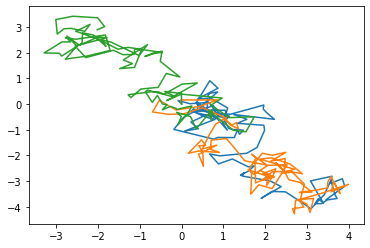

In [4]:
A = np.array([[0.9, 1], [1, 0.9]])
sigma = 1

v_gen = Vent(A=A, sigma=sigma, V0=np.zeros(2))

lst_Vt = v_gen(num=3, n=100, T=10)
for Vt in lst_Vt:
    plt.plot(Vt[:, 0], Vt[:, 1])
plt.show()

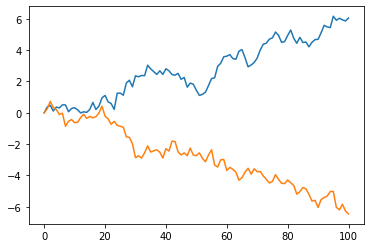

In [5]:
lst_Vt = v_gen(num=3, n=100, T=10)
plt.plot(lst_Vt[2])
plt.show()

(2, 2)


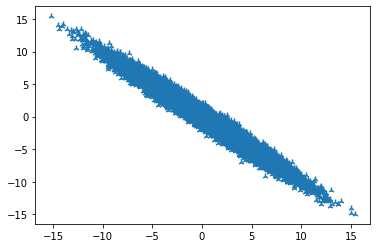

In [53]:
A_inv = np.linalg.inv(A)
exp_2At = scipy.linalg.expm(-2*A*T)
var = sigma*sigma/2 * np.matmul(A_inv, np.eye(2)-exp_2At)
std = np.linalg.cholesky(var)
print(std.shape)
VT = np.random.normal(size=(num, 2, 1))
VT = np.matmul(std, VT).reshape(num, 2)
plt.scatter(VT[:, 0], VT[:, 1], marker='2')
plt.show()

## Define the environment class.
This environment specifies the movement equation and loss function.

In [42]:
class Env:
    def __init__(self, v_init, G, lam, D, A, sigma, V0, device='cpu'):
        self.v_init = torch.tensor(v_init).to(device).view(1, -1)
        self.G = torch.tensor(G).to(device).view(1, -1)
        self.lam = torch.from_numpy(np.array(lam)).to(device)
        self.D = torch.from_numpy(np.array(D)).to(device)
        self.v_gen = Vent(A, sigma, V0)
        self.device = device
        
    def move_x(self, X, t, Vt, Ut, dt):
        term1 = self.v_init * dt
        term2 = self.G/2 * ((t+dt)**2 - t**2)
        term3 = self.lam * X * dt
        term4 = Vt * dt
        term5 = Ut * dt
        
        return X + term1 + term2 - term3 + term4 + term5
#         return X
        
    def loss_terminal(self, XT):
        u1 = ((XT[:, 0] - self.D) - XT[:, 1]) / torch.tensor(np.sqrt(2)).to(self.device).float()
        u2 = ((XT[:, 0] - self.D) + XT[:, 1]) / torch.tensor(np.sqrt(2)).to(self.device).float()

        return (u1 + u1*(u1>0))**2 + u2**2
    
    def process_X(self, X0, num, T, N, U, V=None):
        if V is None:
            V = self.v_gen(num, n=N, T=T)
            V = torch.from_numpy(V)
            
        dt = T/N
        lst_t = np.arange(N+1) * dt
        V = V.to(self.device)
        X = torch.zeros_like(V[:,0]).to(self.device).float()
        X[:] = X0
        loss_u = torch.zeros(len(X)).to(self.device).float()
        for i in range(1, N+1):
            t = lst_t[i-1]
            if i%10 == 1:
                u = U(t, X)
#                 loss_u += torch.linalg.norm(u, dim=1) * dt * 10
                loss_u += torch.linalg.norm(u, dim=1)**2 * dt*10
            X = self.move_x(X, t=t, Vt=V[:, i-1], Ut=u, dt=dt)
        
        loss_T = self.loss_terminal(X)
        loss = loss_u + loss_T
        assert loss.shape==(num,)
        loss = torch.mean(loss)
        return X, loss
    
    def trace_X(self, X0, num, T, N, U, V=None, ret_loss=False, ret_wind=False, ret_U=False):
        if V is None:
            V = self.v_gen(num, n=N, T=T)
            V = torch.from_numpy(V)
            
        dt = T/N
        lst_t = np.arange(N+1) * dt
        V = V.to(self.device)
        X = torch.zeros_like(V).to(self.device).float()
        Ut = torch.zeros_like(V)[:, :-1]
        X[:, 0] = X0
        loss_u = torch.zeros(len(X)).to(self.device).float()
        for i in range(1, N+1):
            t = lst_t[i-1]
            if i%10 == 1:
                u = U(t, X[:, i-1])
#                 loss_u += torch.linalg.norm(u, dim=1) * dt * 10
                loss_u += torch.linalg.norm(u, dim=1)**2 * dt*10
            Ut[:, i-1] = u
            X[:, i] = self.move_x(X[:, i-1], t=t, Vt=V[:, i-1], Ut=u, dt=dt)
        
        loss_T = self.loss_terminal(X[:, -1])
        loss = loss_u + loss_T
        loss = torch.mean(loss)
        ret = [X]
        if ret_loss:
            ret.append(loss)
        if ret_wind:
            ret.append(V)
        if ret_U:
            ret.append(Ut)
        
        if len(ret) == 1:
            return X
        else:
            return ret

### Test of environment class.

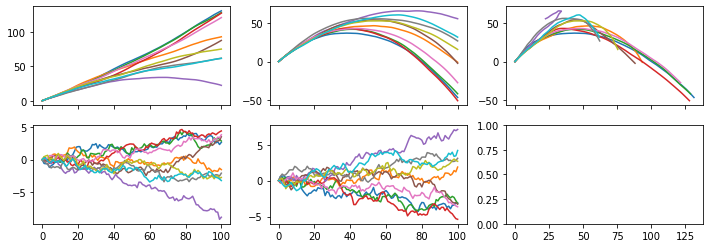

In [72]:
T = 10
N = 100
A = np.array([[.9, 1], [1, .9]])
sigma = 1
V0 = np.array([0, 0])
num = 10

D = 100
G = np.array([0, -4.0])
v_init = np.array([D/T, (T/2)*np.linalg.norm(G)]) 
lam = 0.01
env = Env(v_init=v_init, G=G, D=D, lam=lam, A=A, sigma=sigma, V0=V0, device='cpu')


v_gen = Vent(A=A, sigma=sigma, V0=np.zeros(2))
V = v_gen(num=num, n=N, T=T)
V = torch.from_numpy(V)
# V = torch.zeros_like(V)
U = lambda t, x : torch.zeros_like(x) 
X0 = torch.zeros(2)
X = torch.zeros_like(V)
X[:, 0] = X0
lst_t = np.arange(N+1)*T/N
with torch.no_grad():
    for i in range(1, N+1):
        t = lst_t[i]
        X[:, i] = env.move_x(X[:, i-1], t=t, Vt=V[:, i-1], Ut=V[:,i-1], dt=T/N)
        
        
fig, axs = plt.subplots(2, 3, sharex='col', figsize=(12, 4))
for i in range(num):
    x = X[i]
    axs[0][0].plot(x[:, 0])
    axs[0][1].plot(x[:, 1])
    axs[0][2].plot(x[:, 0], x[:, 1])
    v = V[i]
    axs[1][0].plot(v[:, 0])
    axs[1][1].plot(v[:, 1])
    
plt.show()

## Define the model training function.

In [190]:
def control_fit(A, sigma, V0, v_init, G, lam, D, 
                model = None, lr_lambda = None,
                dim_hid=[12], N=100, T=10, 
                batch_size=2400, train_size=7200, test_size=2000, num_epoch=50, CUDA=True,
                verbose=False):
    '''
    Function used to generate a trained model.
    * Params:
    -----------
    A : Matrix, (dim, dim), for V, of which dVt = -AVtdt + sigma dWt.
    sigma : float. 
    dim_hid : lst of hidden layer dimensions.
    
    * Return:
    -----------
    model : An instance of class Control.
    '''
    
    assert len(A.shape)==2
    dim = A.shape[0]
    assert A.shape[1]==dim and V0.shape==(dim,)
    
    
    # Define the model
    CUDA = CUDA and torch.cuda.is_available()
    if model is None:
        model = Control(dim=dim, dim_hid=dim_hid, CUDA=CUDA)
    device = model.device
    if verbose:
        print(f'Using device {device}.')
    model.to(device)
    
    # Environment
    env = Env(v_init=v_init, G=G, lam=lam, D=D, A=A, sigma=sigma, V0=V0, device=device)
    v_gen = env.v_gen
    
    # Training
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    if lr_lambda is None:
        lr_lambda = lambda epoch : 0.95 if epoch%10==0 else 1
    lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lr_lambda)
    loss_list = []
    
#     fig, ax = plt.subplots()
#     ax.set_xlim(left=1, right=num_epoch+1)
    
    lst_t = np.arange(101) * 10/100
    test_loss = np.Inf
    it_epoch = tqdm(range(num_epoch))
    for epoch in it_epoch:
#     for epoch in range(num_epoch):
        v_train = v_gen(num=train_size, n=N, T=T) # Of shpae (num, n+1, 2).
        v_train = torch.from_numpy(v_train).to(device)
        v_test = v_gen(num=test_size, n=N, T=T)
        v_test = torch.from_numpy(v_test).to(device)
        
        for j in range(0, train_size, batch_size):
            model.zero_grad()
            k = j+batch_size if j+batch_size<train_size else train_size
            V = v_train[j:k] # The wind to be processed in this batch.
            
            X0 = torch.zeros(dim).to(device)
#             X, loss = env.process_X(X0=X0, num=batch_size, T=T, N=N, U=model)
            X, loss = env.process_X(X0=X0, num=len(V), T=T, N=N, U=model, V=V)
#             loss = torch.mean(loss)
            loss.backward()
            optimizer.step()
        lr_scheduler.step()    
        
        with torch.no_grad():
            X, loss = env.process_X(X0=X0, num=test_size, T=T, N=N, U=model, V=v_test)
            test_loss = loss.cpu().numpy()
            loss_list.append(test_loss)
#             if epoch % 10 == 0 and verbose:
#                 print(f'Epoch {epoch}, loss is {test_loss}.')
        it_epoch.set_postfix({'Test loss': test_loss})
    
    plt.plot(np.arange(1, num_epoch+1), loss_list, color='r')
    plt.xlim(left=1, right=num_epoch+2)
    plt.show()

    return model
    
    

## Model Train and Test

Here we train multiple models with diffirent layer sizes, and test their performances.

In [176]:
def model_test(lst_model, env, num, T=10, N=100, plot=True):
    X0 = torch.zeros(2)
    num_model = len(lst_model)
    V = torch.from_numpy(env.v_gen(num=num, n=N, T=T)).to(env.device)
    lst_t = np.arange(N+1)*T/N
    
    lst_loss = []
    if plot:
        fig, axs = plt.subplots(num_model*2+1, 3, sharex='col',  figsize=(12, num_model*2*3+3))
    with torch.no_grad():
        for i, model in enumerate(lst_model):
            X, loss, U = env.trace_X(X0=X0, num=num, T=T, N=N, U=model, V=V,
                                    ret_loss=True, ret_U=True)
            lst_loss.append(loss.cpu().numpy())
            if plot:
                X = X.cpu().numpy()
                U = U.cpu().numpy()
                axs[2*i+1][0].set_title(f'model {i}, loss {loss.cpu()}')
                axs[2*i+1][0].plot(lst_t, X[:, :, 0].T)
                axs[2*i+1][1].plot(lst_t, X[:, :, 1].T)
                axs[2*i+1][2].plot(X[:, :, 0].T, X[:, :, 1].T)
                axs[2*i+1][2].axvline(x=100, color='r')
                axs[2*i+2][0].plot(lst_t[:-1], U[:, :, 0].T)
                axs[2*i+2][1].plot(lst_t[:-1], U[:, :, 1].T)
    if plot:
        V = V.cpu()
        axs[0][0].set_title(f'wind')
        axs[0][0].plot(lst_t, V[:, :, 0].T)
        axs[0][1].plot(lst_t, V[:, :, 1].T)
    
        plt.show()
    
    return np.array(lst_loss)

Using device cuda:0.


Epoch 0, loss is 493.18757451449017.
Epoch 10, loss is 129.729409195089.
Epoch 20, loss is 126.83741800519738.
Epoch 30, loss is 122.23075894180381.
Epoch 40, loss is 123.17139040889431.
Epoch 50, loss is 117.70071554255428.
Epoch 60, loss is 115.26829165209855.
Epoch 70, loss is 121.89101911187885.
Epoch 80, loss is 131.0408389992766.
Epoch 90, loss is 121.08994893879412.
Epoch 100, loss is 125.44286742425655.
Epoch 110, loss is 123.43549378863868.
Epoch 120, loss is 122.60130362369955.
Epoch 130, loss is 120.88374213578398.
Epoch 140, loss is 127.72338990225276.
Epoch 150, loss is 125.40067522407857.
Epoch 160, loss is 123.27022479178726.
Epoch 170, loss is 127.47050675095295.
Epoch 180, loss is 123.17983697867095.
Epoch 190, loss is 123.1079225882693.
Epoch 200, loss is 120.81869754128279.
Epoch 210, loss is 121.11290279790605.
Epoch 220, loss is 117.08430236209345.
Epoch 230, loss is 124.57823925171891.
Epoch 240, loss is 123.34983798344105.
Epoch 250, loss is 128.20641282887738.
E

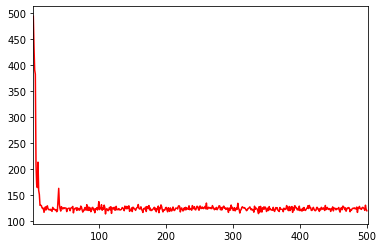

In [166]:
T = 10
N = 100
dim_hid = [19, 9, 8]
lst_t = np.arange(N+1) * T/N
A = np.array([[.9, 1], [1, .9]])
sigma = 1
V0 = np.array([0, 0])

D = 100
G = np.array([0, -4.0])
v_init = np.array([D/T, (T/2)*np.linalg.norm(G)]) 
lam = 0.01

model_5 = control_fit(A=A, sigma=sigma, V0=V0, v_init=v_init, lam=lam, G=G, D=D, 
                      batch_size=2400, train_size=72000, test_size=10000,
                    dim_hid=dim_hid, num_epoch=500, verbose=True)

Using device cuda:0.


<ipython-input-99-b62376bac291>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).to(self.device).float()


Epoch 0, loss is 747.6892446683133.
Epoch 10, loss is 484.1752880538432.
Epoch 20, loss is 358.48242115002773.
Epoch 30, loss is 295.8653429356714.
Epoch 40, loss is 273.47583157700325.
Epoch 50, loss is 233.74330438603735.
Epoch 60, loss is 226.29361641074829.
Epoch 70, loss is 231.91807030087543.
Epoch 80, loss is 252.1429762170653.
Epoch 90, loss is 178.62822611088737.
Epoch 100, loss is 170.14032735621709.
Epoch 110, loss is 166.02767584835314.
Epoch 120, loss is 157.6620190106079.
Epoch 130, loss is 156.00389360629882.
Epoch 140, loss is 151.74011851986177.
Epoch 150, loss is 167.07444285041365.
Epoch 160, loss is 162.8843588608837.
Epoch 170, loss is 154.56485370741225.
Epoch 180, loss is 149.0339632857335.
Epoch 190, loss is 152.96862590750882.
Epoch 200, loss is 149.90412987330419.
Epoch 210, loss is 155.32644031366226.
Epoch 220, loss is 154.99521557026745.
Epoch 230, loss is 157.239592071024.
Epoch 240, loss is 153.6182339840416.
Epoch 250, loss is 166.13703874117766.
Epoch 2

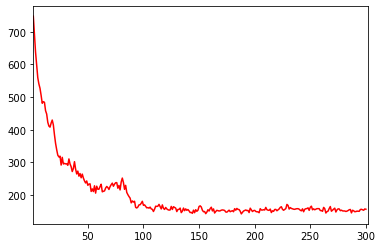

In [147]:
lr_lambda = lambda epoch : 0.95
model_4 = control_fit(A=A, sigma=sigma, V0=V0, v_init=v_init, lam=lam, G=G, D=D, model=model_4,
                      batch_size=2400, 
                    dim_hid=dim_hid, num_epoch=300, verbose=True)

Using device cuda:0.


Epoch 0, loss is 454.7519319353522.
Epoch 10, loss is 124.12231536663641.
Epoch 20, loss is 123.8519445754488.
Epoch 30, loss is 122.31978916444395.
Epoch 40, loss is 123.089685535436.
Epoch 50, loss is 123.1606239605124.
Epoch 60, loss is 122.07872808866465.
Epoch 70, loss is 121.69660312996866.
Epoch 80, loss is 125.02154313029112.
Epoch 90, loss is 122.90700874119152.
Epoch 100, loss is 120.47035424326974.
Epoch 110, loss is 122.62645770556296.
Epoch 120, loss is 120.31900231627192.
Epoch 130, loss is 123.12858439062728.
Epoch 140, loss is 122.60957395840408.
Epoch 150, loss is 119.82909959883936.
Epoch 160, loss is 120.42244188375066.
Epoch 170, loss is 118.94211493535694.
Epoch 180, loss is 119.73648362661825.
Epoch 190, loss is 118.21735612445333.
Epoch 200, loss is 119.1624245324161.
Epoch 210, loss is 118.81214580030178.
Epoch 220, loss is 119.31398451899342.
Epoch 230, loss is 118.66812105521093.
Epoch 240, loss is 119.16119663717626.
Epoch 250, loss is 121.99263861754066.
Epo

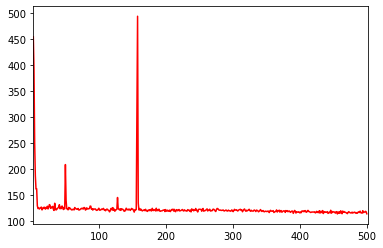

In [181]:
dim_hid = [20, 10, 10]

model_6 = control_fit(A=A, sigma=sigma, V0=V0, v_init=v_init, lam=lam, G=G, D=D, 
                      batch_size=2400, train_size=72000, test_size=10000,
                    dim_hid=dim_hid, num_epoch=500, verbose=True)

Using device cuda:0.


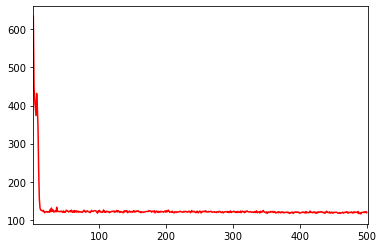

In [191]:
dim_hid = [20, 10, 10]

model_7 = control_fit(A=A, sigma=sigma, V0=V0, v_init=v_init, lam=lam, G=G, D=D, 
                      batch_size=2400, train_size=72000, test_size=10000,
                    dim_hid=dim_hid, num_epoch=500, verbose=True)

In [192]:
time_now = datetime.now()
str_now = time_now.strftime('%b_%d_%H_%M_%S')
torch.save(model_7.state_dict(), f'./output/model_7_{str_now}.mod')

### Test resualts.
We have trained `model_4`, `model_5`, `model_6` and `model_7`. 
Here we use the `model_test` function defined above to test their performances, with a blank control `func_U` to compare.

Firstly we use 50000 samples to estimate their expected losses, and then we plot 5 traces of their control process.

<ipython-input-99-b62376bac291>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).to(self.device).float()


[ 154.08105  123.20489  116.15728  119.34045 1721.4393 ]


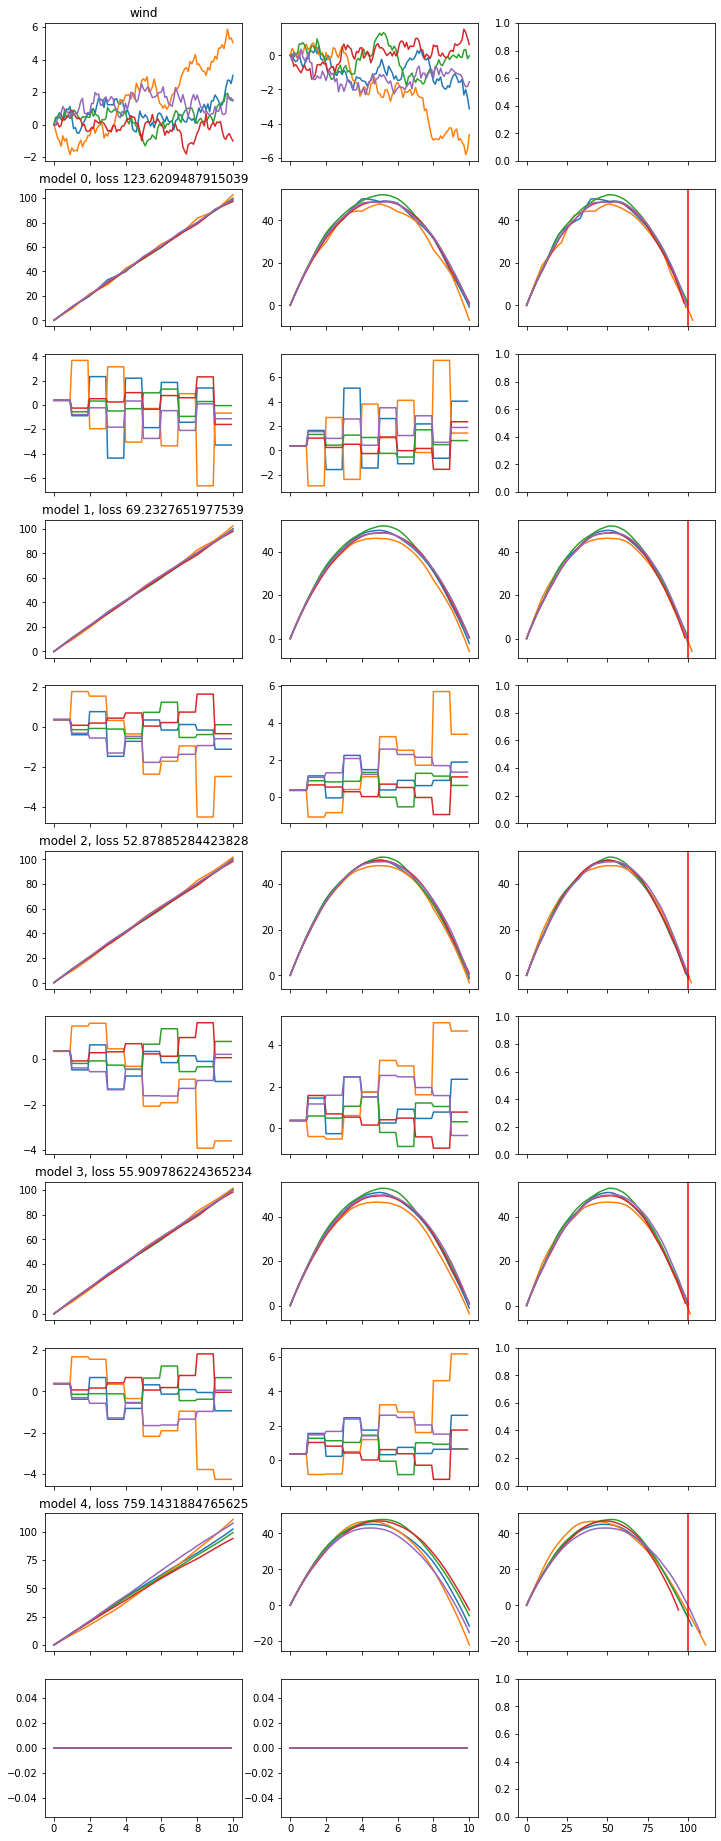

array([123.62095 ,  69.232765,  52.878853,  55.909786, 759.1432  ],
      dtype=float32)

In [194]:
T = 10
N = 100
num = 5
env = Env(v_init=v_init, G=G, D=D, lam=lam, A=A, sigma=sigma, V0=V0, device='cuda:0')
lst_model = [model_4, model_5, model_6, model_7, func_U]

print(model_test(lst_model, env, num=50000, plot=False))
model_test(lst_model, env, num=num, plot=True)

We observe that `model_6` has the best performance, i.e., the least mean loss.